In [ ]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

import os, sys

if IN_COLAB == True:
    %pip install einops
    %pip install jaxtyping
    %pip install transformer_lens
    %pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python
else:
    from IPython import get_ipython
    ipython = get_ipython()
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.0/106.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 120.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 100.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import sys
import plotly.express as px
import torch as t
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import numpy as np
import einops
import copy
from jaxtyping import Int, Float
from typing import List, Optional, Tuple
import functools
from tqdm import tqdm
from IPython.display import display
import webbrowser
import gdown
from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
import circuitsvis as cv

from plotly_utils import imshow, hist, plot_comp_scores, plot_logit_attribution, plot_loss_difference

device = t.device("cuda" if t.cuda.is_available() else "cpu")

MAIN = __name__ == "__main__"

In [ ]:
t.set_grad_enabled(True)

In [ ]:
print(device)

cuda


In [ ]:
# EXTRA STUFF I HAD TO INCLUDE
import wandb
from dataclasses import dataclass
import matplotlib.pyplot as plt
import random
%matplotlib inline
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# THINGS TO DOWNLOAD THE END MODEL
!pwd

current_dir = "/Users/oscarbalcells/Desktop/ARENA_2.0/chapter1_transformers/exercises/part1_transformer_from_scratch/"
desktop_dir = "/Users/oscarbalcells/Desktop/"
grokking_dir = pathlib.Path("/Users/oscarbalcells/Desktop/Grokking")

os.chdir(desktop_dir)

if not grokking_dir.exists():
    !git clone https://github.com/neelnanda-io/Grokking.git

full_run_data_path = (grokking_dir / "full_run_data.pth").resolve()
if not full_run_data_path.exists():
    url = "https://drive.google.com/uc?id=12pmgxpTHLDzSNMbMCuAMXP1lE_XiCQRy"
    output = str(full_run_data_path)
    gdown.download(url, output)

full_run_data = t.load(full_run_data_path, map_location=device)

os.chdir(current_dir)

In [ ]:
def cross_entropy_high_precision(logits, labels):
    # Shapes: batch x vocab, batch
    # Cast logits to float64 because log_softmax has a float32 underflow on overly
    # confident data and can only return multiples of 1.2e-7 (the smallest float x
    # such that 1+x is different from 1 in float32). This leads to loss spikes
    # and dodgy gradients
    logprobs = logits.to(t.float64).log_softmax(dim=-1)
    prediction_logprobs = t.gather(logprobs, index=labels[:, None], dim=-1)
    loss = -t.mean(prediction_logprobs)
    return loss

In [ ]:
# what is this??
def fourier_embed(model):
    W_E_fourier = (model.embed.W_E[:, :-1] @ fourier_basis.T)
    return to_numpy(einops.reduce(W_E_fourier.pow(2), 'resid vocab -> vocab', 'sum'))
# Plot every 200 epochs so it doesn't overwhelm Colab
get_metrics(model, metric_cache, fourier_embed, 'fourier_embed')#, reset=True)
animate_lines(metric_cache['fourier_embed'][::2],
              snapshot_index = epochs[::2],
              snapshot='Epoch',
              hover=fourier_basis_names,
              animation_group='x',
              title='Norm of Fourier Components in the Embedding Over Training')

In [ ]:
p = 113

cfg = HookedTransformerConfig(
    n_layers = 1,
    d_vocab = p+1,
    d_model = 128,
    d_mlp = 4 * 128,
    n_heads = 4,
    d_head = 128 // 4,
    n_ctx = 3,
    act_fn = "relu",
    normalization_type = None,
    device = device
)

In [ ]:
# WARNING!!! If you rerun this cell you will reset the model
model = HookedTransformer(cfg).to(device)

Moving model to device:  cuda


In [ ]:
@dataclass
class TransformerTrainingArgs():
	batch_size = int(p**2 / 3 + 1)
	epochs = 50000
	lr = 1e-3
	weight_decay = 1.0
	frac_train = 0.3
	wandb_project: Optional[str] = "grokking"
	wandb_name: Optional[str] = None
	use_wandb = True
	checkpoint_path: str = "/content/gdrive/MyDrive/ML/grokking_model_checkpoints.pt"
	log_frequency: int = 500
	checkpoint_frequency: int = 5000
	initial_step: int = 450


args = TransformerTrainingArgs()

loss,█▇▇▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,█▁
true_accuracy,▁█
loss,0.02062
train_accuracy,0.33473
true_accuracy,0.00694


Initial validation accuracy is [450, 0.0371406190097332]
Initial train accuracy is [450, 1.0]


  9%|▉         | 4550/50000 [32:47<5:59:39,  2.11it/s]

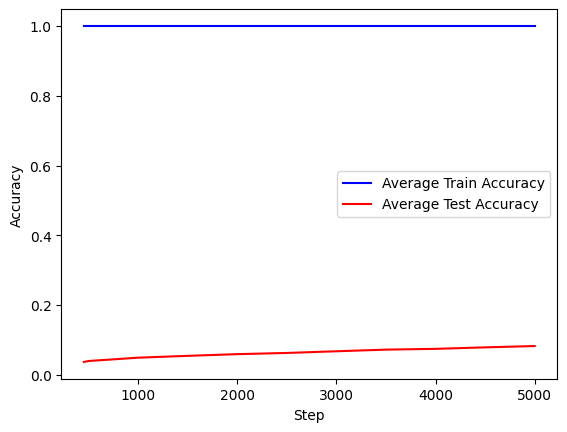

 19%|█▉        | 9550/50000 [1:12:00<5:39:58,  1.98it/s]

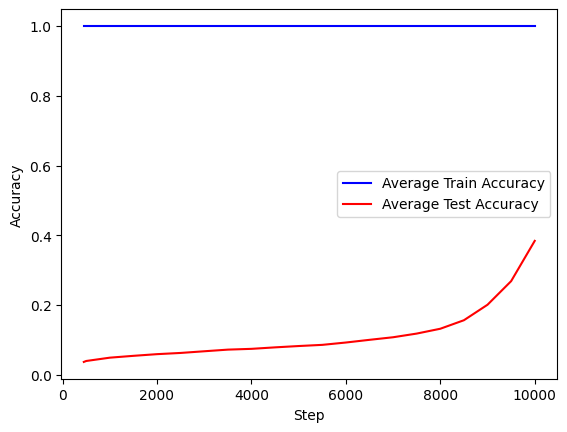

 29%|██▉       | 14550/50000 [1:59:19<5:53:41,  1.67it/s]

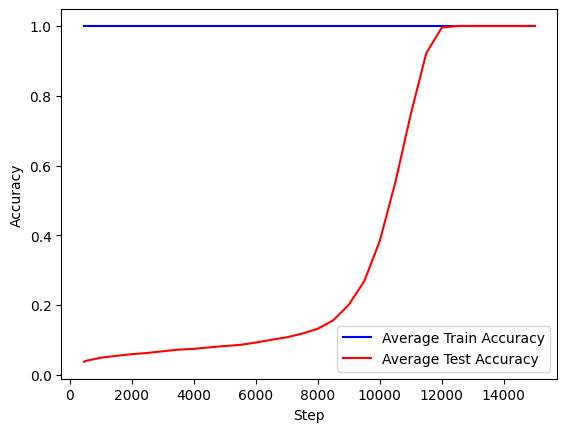

 39%|███▉      | 19550/50000 [2:54:17<5:52:08,  1.44it/s]

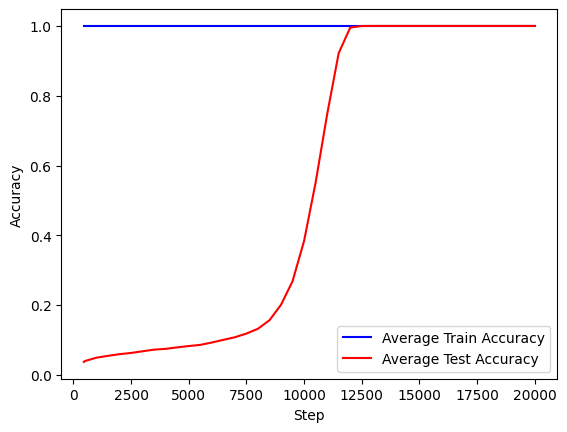

 44%|████▍     | 22035/50000 [3:24:32<5:46:12,  1.35it/s]

In [ ]:
# Before you run check:
# 1) Whether you actually want to turn wandb off/on
# 2) Whether the logging frequency is ok
# 3) Whether the number of epochs is ok

accuracies_logged = []

class TransformerTrainer:
	def __init__(self, args: TransformerTrainingArgs, model: HookedTransformer):
		super().__init__()
		self.model = model
		self.args = args
		self.optimizer = t.optim.AdamW(self.model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
		self.dataset_dict = dict()
		self.is_train = []
		self.is_test = []
		self.step = self.args.initial_step
		self.use_wandb = self.args.use_wandb

		# one step is roughly one epoch of training
		self.train_accuracy = []
		self.val_accuracy = []

		# we generate the data and store it in `self.dataset_dict`
		train, test = TransformerTrainer.gen_train_test(args.frac_train)
		self.dataset_dict = {
			"train": train,
			"test": test
		}

		self.checkpoints = {}
		# self.checkpoints = t.load("/content/gdrive/MyDrive/ML/grokking_model_checkpoints.pt")

	def training_step(self, batch: Int[Tensor, "batch seq"]) -> float:
		self.model.train()
		batch = batch.to(device)
		logits = self.model(batch)[:,-1]
		labels = t.tensor([(a+b)%p for a,b,_ in batch], device=device)
		loss = cross_entropy_high_precision(logits, labels)
		loss.backward()
		self.optimizer.step()
		self.optimizer.zero_grad()
		self.step += 1
		return loss.item()

	@t.inference_mode()
	def validation_step(self, batch: Int[Tensor, "batch seq"]):
		batch = batch.to(device)
		logits: Tensor = self.model(batch)[:,-1]
		predicted_tokens = logits.argmax(dim=-1)
		labels = t.tensor([(a+b)%p for a,b,_ in batch], device=device)
		loss = cross_entropy_high_precision(logits, labels)
		predictions = (predicted_tokens == labels).flatten()
		return predictions

	def log_accuracies(self):
		val_predictions = t.concat([self.validation_step(batch) for batch in self.test_loader()])
		val_accuracy = val_predictions.float().mean().item()
		train_predictions = t.concat([self.validation_step(batch) for batch in self.train_loader()])
		train_accuracy = train_predictions.float().mean().item()
		self.train_accuracy.append([self.step, train_accuracy])
		self.val_accuracy.append([self.step, val_accuracy])
		accuracies_logged.append(["train", self.step, train_accuracy])
		accuracies_logged.append(["test", self.step, val_accuracy])
		if self.use_wandb:
			wandb.log({"true_accuracy": val_accuracy, "train_accuracy": train_accuracy}, step=self.step)

	def train(self):
		if self.use_wandb:
			wandb.init(project=self.args.wandb_project, name=self.args.wandb_name, config=self.args)

		# initial accuracy on train and test set
		self.log_accuracies()
		print(f"Initial validation accuracy is {self.val_accuracy[-1]}")
		print(f"Initial train accuracy is {self.train_accuracy[-1]}")

		for epoch in tqdm(range(self.args.epochs)):
			for i, batch in enumerate(self.train_loader()):
				loss = self.training_step(batch)
				if self.use_wandb:
					wandb.log({"loss": loss}, step=self.step)


			if (self.step - 1) % self.args.log_frequency == 0:
				self.log_accuracies()

			if (self.step - 1) % self.args.checkpoint_frequency == 0:
				self.save_checkpoint()
				self.plot_loss_curves()

		if self.use_wandb:
			wandb.finish()

		self.save_checkpoint()
		self.plot_loss_curves()

	@staticmethod
	def gen_train_test(frac_train: float, seed: int = 0):
		pairs = [(i, j, p) for i in range(p) for j in range(p)]
		random.seed(seed)
		random.shuffle(pairs)
		div = int(len(pairs) * frac_train)
		return t.tensor(pairs[:div]), t.tensor(pairs[div:])

	def plot_loss_curves(self):
		if len(self.train_accuracy) == 0 and len(self.test_accuracy) == 0:
			return
		if len(self.train_accuracy) > 0:
			plt.plot(np.array(self.train_accuracy)[:,0], np.array(self.train_accuracy)[:,1], color="blue", label="Average Train Accuracy")
		if len(self.val_accuracy) > 0:
			plt.plot(np.array(self.val_accuracy)[:,0], np.array(self.val_accuracy)[:,1], color="red", label="Average Test Accuracy")
		plt.xlabel("Step")
		plt.ylabel("Accuracy")
		plt.legend()
		plt.show()

	def save_checkpoint(self):
		self.checkpoints[f"step_{self.step}"] = {
			'model_state_dict': copy.deepcopy(self.model.state_dict()),
			'true_accuracy': self.val_accuracy[-1],
			'train_accuracy': self.train_accuracy[-1],
		}
		t.save(self.checkpoints, self.args.checkpoint_path)

	def train_loader(self) -> t.utils.data.DataLoader:
		return t.utils.data.DataLoader(self.dataset_dict["train"], batch_size=self.args.batch_size, shuffle=True, num_workers=4, pin_memory=True)


	def test_loader(self) -> t.utils.data.DataLoader:
		return t.utils.data.DataLoader(self.dataset_dict["test"], batch_size=self.args.batch_size, shuffle=False, num_workers=4, pin_memory=True)

trainer = TransformerTrainer(args, model)
trainer.train()

#### Making sure that the checkpoints are saved correctly

In [ ]:
def get_loss(model, data, with_grad = False):
    if with_grad:
        model.train()
        logits = model(data)[:,-1]
        labels = t.tensor([(a+b)%p for a,b,_ in data], device=device)
        return cross_entropy_high_precision(logits, labels)
    else:
        with t.no_grad():
            print(data)
            logits = model(data)[:,-1]
            labels = t.tensor([(a+b)%p for a,b,_ in data], device=device)
            return cross_entropy_high_precision(logits, labels)


In [ ]:
model_checkpoints = t.load("/content/gdrive/MyDrive/ML/grokking_model_checkpoints.pt")

In [ ]:
model_checkpoints.keys()

dict_keys(['step_1', 'step_31', 'step_61', 'step_91', 'step_100'])

In [ ]:
model_31 = HookedTransformer(cfg).to(device)
model_31.load_state_dict(model_checkpoints["step_31"]["model_state_dict"])
model_61 = HookedTransformer(cfg).to(device)
model_61.load_state_dict(model_checkpoints["step_61"]["model_state_dict"])

Moving model to device:  cuda
Moving model to device:  cuda


<All keys matched successfully>

In [ ]:
train, test = TransformerTrainer.gen_train_test(0.3)
train = train.to(device)
test = test.to(device)